# Solving PDE - Example with Mitchell-Schaeffer model in 2D

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib import animation
from progressbar import ProgressBar, Percentage, Bar

## Domains definition
Square composed of $n_x\times n_y$ elements of size $d_x\times d_y$. $n_x$ elements along $i$ and $n_y$ along $j$.

Height $h = i\cdot n_x$ and width $w = j\cdot n_y$.

$$ \forall p=(x,y)=(i\cdot dx,j\cdot dy) $$

### Fibers anisotropy
Tensor $D=\left[
\begin{array}{ll}
1 & 0\\
0 & r
\end{array}\right]$ in 2D. Conductivity is slowed down in $y$ direction by a factor $r$.

### Stability condition
$$dt\leq \frac{dx^2dy^2}{dy^2+rdx^2}$$

dt = 0.43, Tmax = 100
nx = 20, ny = 20
dx = 1, dy = 1


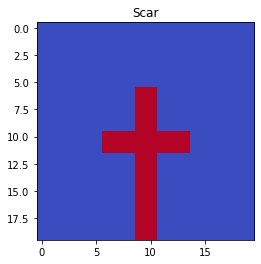

In [2]:
# Time domain size, ms
T_max = 500

# Space domain size, mm
w = h = 20

# intervals in x, y directions, mm
dx = dy = 1  # 1 (fast) or 0.4 (precise)

# fibers anisotropy, r = 1/2.5^2 = 0.16, D=[[1,0],[0,r]] in 2d
r = 0.16

# domain discretization
nx, ny = int(w / dx), int(h / dy)
dx2, dy2 = dx * dx, dy * dy
dt = round(0.5 * dx2 * dy2 / (dy2 + r * dx2), 2)

print(f"dt = {dt}, Tmax = {T_max}")
print(f"nx = {nx}, ny = {ny}")
print(f"dx = {dx}, dy = {dy}")
steps = (nx, ny)

# scar domain mask
scar = np.zeros(steps, dtype=bool)
add_a_scar = True

if add_a_scar:
    wx, wy = nx//10, ny//15
    scar[nx//3:, ny//2-wy:ny//2+wy] = 1  # vertical
    scar[nx//2:nx//2+wx, ny//2-4*wy:ny//2+4*wy] = 1  # horizontal
    
    # Plot it
    plt.imshow(scar, cmap='coolwarm')
    plt.title("Scar")

## Mitchell-Schaeffer model

### Parameters
Stimulation is modified to be space-dependant

In [3]:
# MS parameters
tin, tout = 0.3, 6
topen, tclose = 120, 150

# Stimulation
t_stim, vstim = 0.1, 1
T = 500
indices_to_pace = (nx - 1, 0)

def periodic_stimulation_corner(t):
    stim = np.zeros(steps)
    stim[indices_to_pace] = vstim if 0 <= t % T <= t_stim else 0
    return stim

### Diffusion model

Adding a term $$div(D\nabla v) = \frac{\partial^2 v}{\partial x^2}+r \frac{\partial^2 v}{\partial y^2}$$ with $D=\left[
\begin{array}{ll}
1 & 0\\
0 & r
\end{array}\right]$.

With centered finite differences,
$$\frac{\partial^2 v}{\partial x^2} \approx \frac{v^n_{i+1,j}-2v^n_{i,j}+v^n_{i-1,j}}{\Delta x^2}$$
and
$$r\frac{\partial^2 v}{\partial y^2} \approx r\frac{v^n_{i,j+1}-2v^n_{i,j}+v^n_{i,j-1}}{\Delta y^2}$$

### Boundary conditions

Free-conditions: the scheme is shifted for points on boundary. For example for top left corner (0,0), we have $$\frac{\partial^2 v}{\partial x^2} \approx \frac{v^n_{i+2,j}-2v^n_{i+1,j}+v^n_{i,j}}{\Delta x^2}$$
and
$$r\frac{\partial^2 v}{\partial y^2} \approx r\frac{v^n_{i,j+2}-2v^n_{i,j+1}+v^n_{i,j}}{\Delta y^2}$$


<img src="mesh_MS2D.png" alt="Mesh, discretization and boundary conditions" style="width: 500px;"/>

In [4]:
# Import the diffusion part
from MS_PDE import Div as _div
Div = lambda v: _div(v, r, dx2, dy2, nx, ny, scar)

# Convert matrix notation to vectorial one
from MS_PDE import pack
from MS_PDE import unpack as _unpack
unpack = lambda x: _unpack(x, steps)

# (lambda functions are just helpers to avoid calling constant variables each time)

# Examples
a = np.arange(4).reshape((2,2))
b = a + 10
print("a =", a)
print("b =", b)
c = pack(a, b)
print("c =", c)
aa, bb = _unpack(c, steps=(2,2))
print("a is aa:", np.array_equal(aa, a))
print("b is bb:", np.array_equal(bb, b))

a = [[0 1]
 [2 3]]
b = [[10 11]
 [12 13]]
c = [ 0  1  2  3 10 11 12 13]
a is aa: True
b is bb: True


In [5]:
# Main model, implemented with finite differences in space (diffusion)
# Will be solved a each time step with `sove_ivp`
def Michell_Schaeffer(t, state, tin, tout, topen, tclose, vgate, JStim):
    pbar.update(t)

    v, h = unpack(state)

    # 2 currents
    JIn = lambda v, h: h * v ** 2 * (1 - v) / tin  # (2)
    JOut = lambda v: -v / tout  # (3)

    # System of equations
    # dvdt = JIn(v, h) + JOut(v) + JStim(t)  # (1) # Without diffusion
    dvdt = Div(v) + JIn(v, h) + JOut(v) + JStim(t)  # (1)
    dhdt = (1 - h) / topen  # (4)
    dhdt[np.where(v > vgate)] = -h[np.where(v > vgate)] / tclose  # (4)

    f = pack(dvdt, dhdt)
    return f

## Solve the system

Define the initial conditions $X_0$. Solve with RK scheme in time, unknowns beeing v and h at each mesh point, ordered in a vector as $$\left(v_{0,0}, v_{0,1}, ..., v_{0,n_y-1}, v_{1, 0}, ..., v_{n_x-1, n_y-1}, h_{0,0}, h_{0,1}, ..., h_{0,n_y-1}, h_{1, 0}, ..., h_{n_x-1, n_y-1} \right)$$
This vector has a size $2n_x n_y$.


The initial condition $X_0$ contains the initial values of v and h for each point on the domain.


### Details
**See in the `MS_PDE` module, `pack` and `unpack` methods to convert the unknowns**

We use `np.flatten` to convert matrix notation to vector notation.
The inverse is obtained with `np.reshape((nx,ny))`.

To 'stick' v and h, we use `np.concatenate` and slices to sperate them (`n = z.shape[0] // 2` and `vN, hN = z[:n], z[n:]`).

In [6]:
print("\n-------\nRunning: loop over time steps", flush=True)
pbar = ProgressBar(widgets=[Percentage(), Bar()], maxval=T_max).start()

# Initial conditions
X0 = pack(np.zeros(steps), np.ones(steps))  # v0, h0

# Solve with RK scheme in time
sol = solve_ivp(
    Michell_Schaeffer,
    [0, T_max],
    X0,
    dense_output=True,
    args=(tin, tout, topen, tclose, 0.13, periodic_stimulation_corner),
    max_step=dt,
)
pbar.finish()


-------
Running: loop over time steps


100%|#########################################################################|


## Post processing

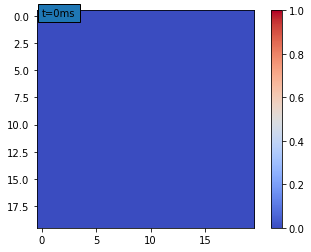

In [7]:
def getSol(t):
    """ Unpack solution in domain at time t """
    return unpack(sol.sol(t))


# Get sol at t=0 to init the image
v, h = getSol(0)
# Create plot
fig = plt.figure()
# And display intial potential map
im = plt.imshow(v, animated=True, vmin=0, vmax=1)
txt_time = plt.text(0, 0, "", bbox=dict(fill=True))


# animation function, plot image at a time i
def animate(i):
    txt_time.set_text(f"t={i}ms")
    v, h = getSol(i)
    im.set_array(v)
    return (im,)


# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, frames=T_max, interval=50, blit=False)
# animate(T_max)
plt.set_cmap("coolwarm")
plt.colorbar()

# Create video (specific for the notebook)
from IPython.display import HTML
HTML(anim.to_html5_video())
# anim.save("Figure.mp4")

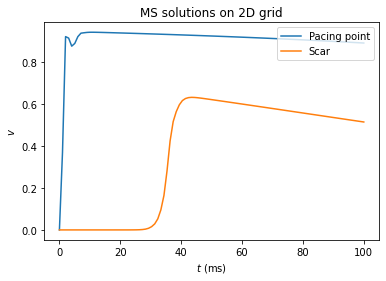

In [8]:
# Plot solution over time in 2 locations on the domain
plt.clf()

# Create x and y axis vectors to store the solutions
T = np.linspace(0, T_max, T_max)
Ys = []

# Select points where to plot the sol
locs = {
    "Pacing point": indices_to_pace,
    "Scar": (nx//3-1, ny//2),
#     "Bottom right": (nx - 1, ny - 1),
}

for t in T:
    v, _ = getSol(t)
    Ys.append([v[l] for l in locs.values()])
    
plt.plot(T, Ys)
plt.title("MS solutions on 2D grid")
plt.legend(locs.keys(), loc="upper right")
plt.xlabel("$t$ (ms)")
plt.ylabel("$v$")
plt.show()
